## Introduction

The goal of this analysis is to find a vectorization of Bon and Nyingma texts such that dimensionality reduction techniques (PCA, t-SNE) allow us to visually distinguish between the two groups of texts


## Prologue: Tokenizing Tibetan texts and setting up dimensionality reduction framework

In [1]:
from collections import Counter
from nltk import ngrams

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from gensim.corpora import Dictionary
from gensim.models import LsiModel, TfidfModel

import itertools
import gensim
import numpy as np
import os
import pybo

import matplotlib.pyplot as plt
%matplotlib inline

Store texts in the following directory structure:

    texts
      Bon
        file1.txt
        file2.txt
        ...
      Nyingma
        file1.txt
        file2.txt
        ...

In [2]:
tok = pybo.BoTokenizer('POS')

Loading Trie...
Time: 4.1502461433410645


Assumptions here:
1. Drop all non-bo text
2. Drop all phrase delimiters (shad)
3. Reduce words to lemmas
4. Strip beginning and ending tseks from lemmas

In [3]:
tsek = '་'

# Create dictionary to map document index back to filename
bon_idx2fname = {}
bon_texts = []
for filename in os.listdir("texts/Bon"):
    if ".txt" in filename:
        with open("texts/Bon/" + filename, 'r', encoding='utf-8-sig') as f:
            bon_idx2fname[len(bon_texts)] = filename
            lemmas = [t.lemma.strip(tsek) for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
            bon_texts.append(lemmas)
            
# Now process nyingma
nyingma_idx2fname = {}
nyingma_texts = []
for filename in os.listdir("texts/Nyingma"):
    if ".txt" in filename:
        with open("texts/Nyingma/" + filename, 'r', encoding='utf-8-sig') as f:
            nyingma_idx2fname[len(nyingma_texts)] = filename
            lemmas = [t.lemma.strip(tsek) for t in tok.tokenize(f.read()) if t.type != "non-bo" and t.pos != "punct"]
            nyingma_texts.append(lemmas)

Helper functions to run PCA, t-SNE, PCA + t-SNE on set of vectors and then plot with matplotlib.

PCA + t-SNE first runs PCA to a medium-dimensionality space (default to 50D) and then runs t-SNE on these intermediate vectors.

In [4]:
# Expects X as array of vectors and colors as array of characters 'r' or 'b'
# If normalize is set to True, use StandardScaler to normalize inputs
def visualize_pca(X, colors=None, normalize=False):
    pca = PCA(n_components=2)
    if normalize:
        scale = StandardScaler()
        X = scale.fit_transform(X)
    pca_X = pca.fit_transform(X)
    plt.clf()
    plt.scatter(pca_X[:,0], pca_X[:,1], c=colors)
    plt.show()

# Perplexity is a parameter of tsne usually set to a value in [5, 50] with higher values for larger datasets
def visualize_tsne(X, perplexity=10, colors=None, normalize=False):
    if normalize:
        scale = StandardScaler()
        X = scale.fit_transform(X)
    tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    tsne_X = tsne.fit_transform(X)
    plt.clf()
    plt.scatter(tsne_X[:,0], tsne_X[:,1], c=colors)
    plt.show()

# K is the number of intermediate PCA dimensions to project X into before t-SNE
def visualize_pca_tsne(X, K=50, perplexity=10, colors=None, normalize=False):
    pca = PCA(n_components=K)
    if normalize:
        scale = StandardScaler()
        X = scale.fit_transform(X)
    pca_X = pca.fit_transform(X)
    
    tsne = TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    tsne_X = tsne.fit_transform(pca_X)
    plt.clf()
    plt.scatter(tsne_X[:,0], tsne_X[:,1], c=colors)
    plt.show()

## Part 1: Word Frequency Analysis

We can now easily compute the most frequent words

In [5]:
all_bon = list(itertools.chain(*bon_texts))
all_nyingma = list(itertools.chain(*nyingma_texts))

bon_words = Counter(all_bon)
nyingma_words = Counter(all_nyingma)

In [6]:
print("10 most common words in Bon texts")
for p in bon_words.most_common(10):
    print("{}: {}\n".format(p[0], p[1]))
    
print("\n10 most common words in Nyingma texts")
for p in nyingma_words.most_common(10):
    print("{}: {}\n".format(p[0], p[1]))

10 most common words in Bon texts
གི: 5345

ལ: 4650

གིས: 2594

ལས: 2205

དང: 2137

ནི: 2064

ནས: 1769

པ: 1606

གོ: 1517

ཀྱང: 1465


10 most common words in Nyingma texts
གི: 1498

ལ: 1192

དང: 574

གིས: 522

གོ: 467

མི: 452

དུ: 447

མེད: 444

ཀྱི: 415

ནི: 360



We switch over to gensim to visualize the discriminative power of these term frequency vectors (normalized)

In [7]:
dct = Dictionary(bon_texts + nyingma_texts)
bon_bows = [dct.doc2bow(t) for t in bon_texts]
nyingma_bows = [dct.doc2bow(t) for t in nyingma_texts]

In [8]:
bon_tfs = []
for t in bon_bows:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    bon_tfs.append(vec / np.linalg.norm(vec))
    
nyingma_tfs = []
for t in nyingma_bows:
    vec = np.zeros(len(dct))
    for k, v in t:
        vec[k] = v
    nyingma_tfs.append(vec / np.linalg.norm(vec))

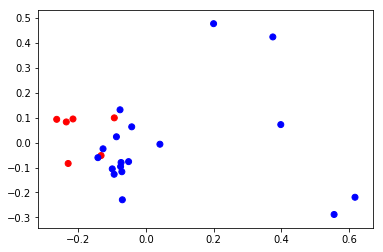

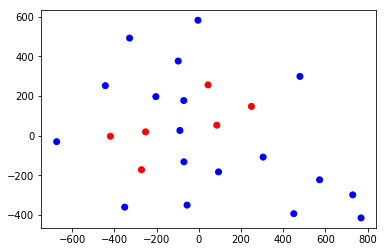

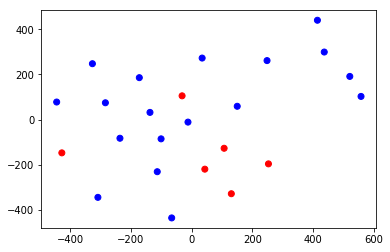

In [9]:
colors = ['r' for _ in range(len(bon_tfs))] + ['b' for _ in range(len(nyingma_tfs))]
visualize_pca(bon_tfs + nyingma_tfs, colors=colors)
visualize_tsne(bon_tfs + nyingma_tfs, colors=colors)
visualize_pca_tsne(bon_tfs + nyingma_tfs, colors=colors)

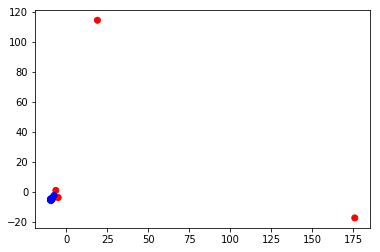

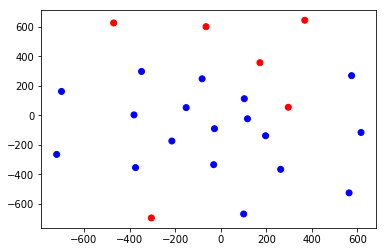

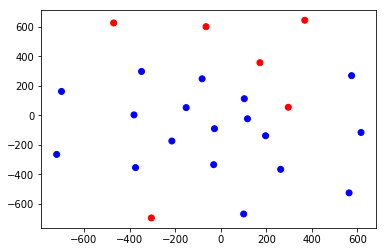

In [10]:
visualize_pca(bon_tfs + nyingma_tfs, colors=colors, normalize=True)
visualize_tsne(bon_tfs + nyingma_tfs, colors=colors, normalize=True)
visualize_pca_tsne(bon_tfs + nyingma_tfs, colors=colors, normalize=True)

## Part 1b: 2 to 5-gram Frequency

We can easily extend this analysis to 2, 3, 4, 5-gram frequency

In [11]:
N=2

bon_ngrams = Counter(ngrams(all_bon, N))
nyingma_ngrams = Counter(ngrams(all_nyingma, N))

print("10 most common {}-grams in Bon texts".format(N))
for p in bon_ngrams.most_common(10):
    print("{}: {}\n".format(tsek.join(p[0]), p[1]))
    
print("\n10 most common {}-grams in Nyingma texts".format(N))
for p in nyingma_ngrams.most_common(10):
    print("{}: {}\n".format(tsek.join(p[0]), p[1]))

10 most common 2-grams in Bon texts
པ་གི: 554

མེད་པ་གི: 441

གི་དོན: 361

དེ་ལ: 274

དེ་ནི: 267

ལ་ཀྱང: 256

བོན་ཉིད: 244

བྱང་ཆུབ་ཀྱིས: 236

བྱ་གོ: 235

ཀྱིས་སེམས: 233


10 most common 2-grams in Nyingma texts
རྨད་དུ: 132

དུ་བྱུང་བ: 132

ཀུན་ཏུ: 100

བྱང་ཆུབ་སེམས: 94

མེད་པ་གི: 82

གི་ཆོས: 77

ཀུན་གྱི: 69

ལ་ཀྱང: 69

ཡིན་གོ: 67

པ་གི: 64



In [12]:
N=3

bon_ngrams = Counter(ngrams(all_bon, N))
nyingma_ngrams = Counter(ngrams(all_nyingma, N))

print("10 most common {}-grams in Bon texts".format(N))
for p in bon_ngrams.most_common(10):
    print(p)
    
print("\n10 most common {}-grams in Nyingma texts".format(N))
for p in nyingma_ngrams.most_common(10):
    print(p)

10 most common 3-grams in Bon texts
(('བྱང་ཆུབ', 'ཀྱིས', 'སེམས'), 204)
(('ཅེས', 'བྱ', 'གོ'), 141)
(('ཅི', 'ལ', 'ཀྱང'), 126)
(('འབྲུ', 'ཏིག', 'སྟེ'), 124)
(('ལ', 'བསྒོམ', 'མོ'), 122)
(('ཏིག', 'སྟེ', 'ངོས'), 116)
(('དེ', 'ལ', 'བྱ'), 114)
(('བཅའ', 'ལ', 'ཏེ'), 113)
(('འཕྲུལ', 'གྱི', 'ལྡེ་མིག'), 112)
(('ལ', 'ཏེ', 'བཤད'), 108)

10 most common 3-grams in Nyingma texts
(('རྨད', 'དུ', 'བྱུང་བ'), 130)
(('བྱང་ཆུབ', 'ཀྱི', 'སེམས'), 56)
(('གི', 'ལེའུ', 'སྟེ'), 52)
(('དུ', 'བྱུང་བ', 'ཉིད'), 44)
(('ཀུན', 'ཏུ', 'བཟང་པོ'), 40)
(('དཔལ', 'ཀུན', 'ཏུ'), 38)
(('ཆེན་པོ', 'རྨད', 'དུ'), 34)
(('བཅོམ་ལྡན་འདས', 'དཔལ', 'ཀུན'), 33)
(('གོ', 'དེ་ནས', 'བཅོམ་ལྡན་འདས'), 32)
(('ཅི', 'ལ', 'ཀྱང'), 31)


In [13]:
N=4

bon_ngrams = Counter(ngrams(all_bon, N))
nyingma_ngrams = Counter(ngrams(all_nyingma, N))

print("10 most common {}-grams in Bon texts".format(N))
for p in bon_ngrams.most_common(10):
    print(p)
    
print("\n10 most common {}-grams in Nyingma texts".format(N))
for p in nyingma_ngrams.most_common(10):
    print(p)

10 most common 4-grams in Bon texts
(('འབྲུ', 'ཏིག', 'སྟེ', 'ངོས'), 116)
(('བཅའ', 'ལ', 'ཏེ', 'བཤད'), 108)
(('ཀྱང', 'དེ', 'ལ', 'བྱ'), 105)
(('གི', 'དམར', 'ཐག', 'དང'), 105)
(('ཅེས', 'ཀྱང', 'དེ', 'ལ'), 101)
(('གི', 'སྒྲར', 'འབྲུ', 'ཏིག'), 97)
(('སྒྲར', 'འབྲུ', 'ཏིག', 'སྟེ'), 95)
(('ཏིག', 'སྟེ', 'ངོས', 'གཟུངས'), 90)
(('སྟེ', 'ངོས', 'གཟུངས', 'གོ'), 90)
(('འབྲུ', 'ལ', 'བཅའ', 'ལ'), 73)

10 most common 4-grams in Nyingma texts
(('རྨད', 'དུ', 'བྱུང་བ', 'ཉིད'), 44)
(('ཆེན་པོ', 'རྨད', 'དུ', 'བྱུང་བ'), 34)
(('བཅོམ་ལྡན་འདས', 'དཔལ', 'ཀུན', 'ཏུ'), 33)
(('གོ', 'དེ་ནས', 'བཅོམ་ལྡན་འདས', 'དཔལ'), 24)
(('ཆོས', 'ཆེན་པོ', 'རྨད', 'དུ'), 23)
(('སྟོང་གསུམ', 'གྱི', 'སྟོང', 'ཆེན་པོ'), 22)
(('བྱུང་བ', 'ཉིད', 'ཡིན', 'གོ'), 22)
(('གསང་བ', 'རྨད', 'དུ', 'བྱུང་བ'), 22)
(('དེ་ནས', 'བཅོམ་ལྡན་འདས', 'དཔལ', 'ཀུན'), 21)
(('རྨད', 'དུ', 'བྱུང་བ', 'ལས'), 21)


In [14]:
N=5

bon_ngrams = Counter(ngrams(all_bon, N))
nyingma_ngrams = Counter(ngrams(all_nyingma, N))

print("10 most common {}-grams in Bon texts".format(N))
for p in bon_ngrams.most_common(10):
    print(p)
    
print("\n10 most common {}-grams in Nyingma texts".format(N))
for p in nyingma_ngrams.most_common(10):
    print(p)

10 most common 5-grams in Bon texts
(('ཅེས', 'ཀྱང', 'དེ', 'ལ', 'བྱ'), 101)
(('གི', 'སྒྲར', 'འབྲུ', 'ཏིག', 'སྟེ'), 91)
(('འབྲུ', 'ཏིག', 'སྟེ', 'ངོས', 'གཟུངས'), 90)
(('ཏིག', 'སྟེ', 'ངོས', 'གཟུངས', 'གོ'), 90)
(('སྒྲར', 'འབྲུ', 'ཏིག', 'སྟེ', 'ངོས'), 88)
(('བཅའ', 'ལ', 'ཏེ', 'བཤད', 'ན'), 69)
(('འབྲུ', 'ལ', 'བཅའ', 'ལ', 'ཏེ'), 65)
(('ལ', 'བཅའ', 'ལ', 'ཏེ', 'བཤད'), 64)
(('ལུང', 'བརྣན', 'ལ', 'བསྒོམ', 'མོ'), 64)
(('དེ', 'འབྱེད', 'འཕྲུལ', 'གྱི', 'ལྡེ་མིག'), 57)

10 most common 5-grams in Nyingma texts
(('ཆོས', 'ཆེན་པོ', 'རྨད', 'དུ', 'བྱུང་བ'), 23)
(('དེ་ནས', 'བཅོམ་ལྡན་འདས', 'དཔལ', 'ཀུན', 'ཏུ'), 21)
(('རྨད', 'དུ', 'བྱུང་བ', 'ཉིད', 'ཡིན'), 21)
(('དུ', 'བྱུང་བ', 'ཉིད', 'ཡིན', 'གོ'), 21)
(('རྨད', 'དུ', 'བྱུང་བ', 'ཉིད', 'གོ'), 19)
(('བཅོམ་ལྡན་འདས', 'དཔལ', 'ཀུན', 'ཏུ', 'བཟང་པོས'), 17)
(('ཆེན་པོ', 'རྨད', 'དུ', 'བྱུང་བ', 'ལས'), 17)
(('གོ', 'དེ་ནས', 'བཅོམ་ལྡན་འདས', 'དཔལ', 'ཀུན'), 16)
(('བཅོམ་ལྡན་འདས', 'དཔལ', 'ཀུན', 'ཏུ', 'བཟང་པོ'), 15)
(('བྱང་ཆུབ', 'ཀྱི', 'སེམས', 'རྨད', 'དུ'), 14)


Let's visualize dimensionality reduction on term frequency vectors (normalized) consisting of all 1-10 grams

In [15]:
ngram_lexicons = [set() for _ in range(10)]
bon_texts_ngrams = []
for t in bon_texts:
    text = []
    for n in range(1, 11):
        grams = [''.join(x) for x in ngrams(t, n)]
        text.extend(grams)
        ngram_lexicons[n-1].update(grams)
    bon_texts_ngrams.append(text)
    
nyingma_texts_ngrams = []
for t in nyingma_texts:
    text = []
    for n in range(1, 11):
        grams = [''.join(x) for x in ngrams(t, n)]
        text.extend(grams)
        ngram_lexicons[n-1].update(grams)
    nyingma_texts_ngrams.append(text)

In [16]:
dct_ngrams = Dictionary(bon_texts_ngrams + nyingma_texts_ngrams)
bon_bows_ngrams = [dct_ngrams.doc2bow(t) for t in bon_texts_ngrams]
nyingma_bows_ngrams = [dct_ngrams.doc2bow(t) for t in nyingma_texts_ngrams]

In [17]:
bon_tfs_ngrams = []
for t in bon_bows_ngrams:
    vec = np.zeros(len(dct_ngrams))
    for k, v in t:
        vec[k] = v
    bon_tfs_ngrams.append(vec / np.linalg.norm(vec))
    
nyingma_tfs_ngrams = []
for t in nyingma_bows_ngrams:
    vec = np.zeros(len(dct_ngrams))
    for k, v in t:
        vec[k] = v
    nyingma_tfs_ngrams.append(vec / np.linalg.norm(vec))

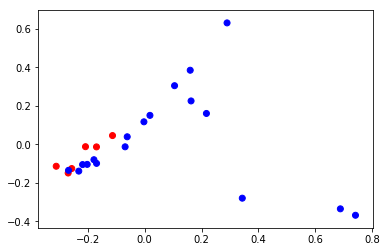

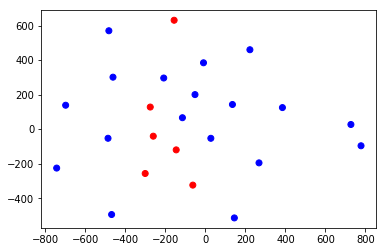

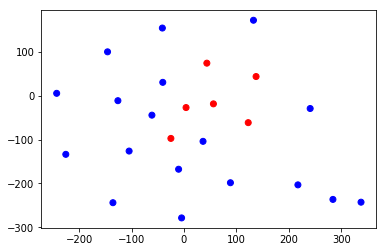

In [18]:
visualize_pca(bon_tfs_ngrams + nyingma_tfs_ngrams, colors=colors)
visualize_tsne(bon_tfs_ngrams + nyingma_tfs_ngrams, colors=colors)
visualize_pca_tsne(bon_tfs_ngrams + nyingma_tfs_ngrams, colors=colors)

## Part 2: tf-idf vectorization

tf-idf vectorization weights the frequency of terms by idf (inverse document frequency), i.e. the less frequently it appears across documents the more highly it is weighted.

There exist several variants for calculating tf, idf, and also several ways of normalizing vectors to avoid biasing toward short documents, etc. We stick with the defaults for now.

In [19]:
tfidf_model = TfidfModel(bon_bows + nyingma_bows)

Now we convert these vectors to np arrays and visualize using PCA and TSNE

In [20]:
bon_tfidfs = []
for t in bon_bows:
    vec = np.zeros(len(dct))
    for k, v in tfidf_model[t]:
        vec[k] = v
    bon_tfidfs.append(vec)
    
nyingma_tfidfs = []
for t in nyingma_bows:
    vec = np.zeros(len(dct))
    for k, v in tfidf_model[t]:
        vec[k] = v
    nyingma_tfidfs.append(vec)

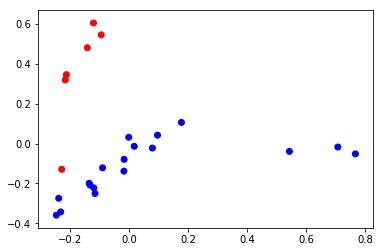

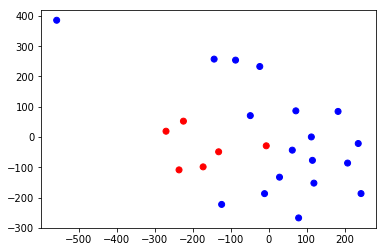

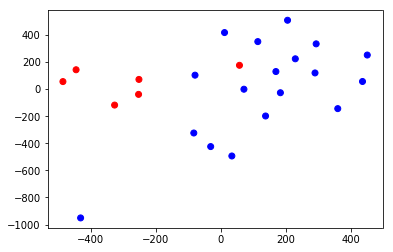

In [21]:
visualize_pca(bon_tfidfs + nyingma_tfidfs, colors=colors)
visualize_tsne(bon_tfidfs + nyingma_tfidfs, colors=colors)
visualize_pca_tsne(bon_tfidfs + nyingma_tfidfs, colors=colors)

## Part 2b: tf-idf with n-grams

We augment the dictionary now with n-grams (up to 10) and run the same analysis

In [22]:
tfidf_model_ngrams = TfidfModel(bon_bows_ngrams + nyingma_bows_ngrams)

In [23]:
bon_tfidfs_ngrams = []
for t in bon_bows_ngrams:
    vec = np.zeros(len(dct_ngrams))
    for k, v in tfidf_model_ngrams[t]:
        vec[k] = v
    bon_tfidfs_ngrams.append(vec)
    
nyingma_tfidfs_ngrams = []
for t in nyingma_bows_ngrams:
    vec = np.zeros(len(dct_ngrams))
    for k, v in tfidf_model_ngrams[t]:
        vec[k] = v
    nyingma_tfidfs_ngrams.append(vec)

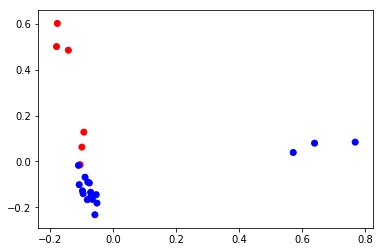

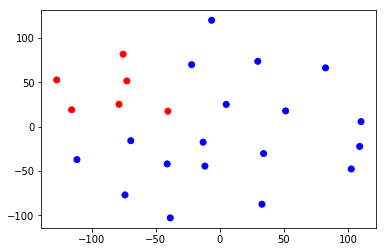

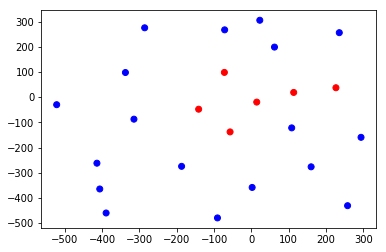

In [24]:
visualize_pca(bon_tfidfs_ngrams + nyingma_tfidfs_ngrams, colors=colors)
visualize_tsne(bon_tfidfs_ngrams + nyingma_tfidfs_ngrams, colors=colors)
visualize_pca_tsne(bon_tfidfs_ngrams + nyingma_tfidfs_ngrams, colors=colors)

## Part 2c: tf-idf with n-grams with weighting

We repeat the previous analysis but now we upweight the vector indices corresponding to n-grams by $e^{0.5n}$ or $2n$

In [25]:
ngram_lens = [len(s) for s in ngram_lexicons]
ngram_idxs = [sum(ngram_lens[:i]) for i in range(len(ngram_lens)+1)]

In [26]:
ngram_lens

[4638, 43022, 84133, 104336, 114887, 121376, 125715, 128820, 131019, 132611]

In [27]:
ngram_idxs

[0,
 4638,
 47660,
 131793,
 236129,
 351016,
 472392,
 598107,
 726927,
 857946,
 990557]

In [28]:
bon_tfidfs_ngrams_exp = []
for v in bon_tfidfs_ngrams:
    v = np.copy(v)
    for n in range(10):
        v[ngram_idxs[n]:ngram_idxs[n+1]] *= np.exp((n+1) / 2)
    bon_tfidfs_ngrams_exp.append(v)
    
nyingma_tfidfs_ngrams_exp = []
for v in nyingma_tfidfs_ngrams:
    v = np.copy(v)
    for n in range(10):
        v[ngram_idxs[n]:ngram_idxs[n+1]] *= np.exp((n+1) / 2)
    nyingma_tfidfs_ngrams_exp.append(v)

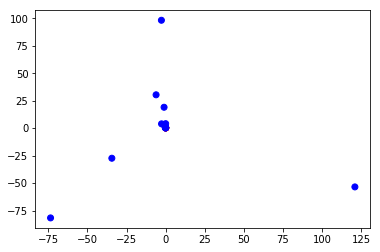

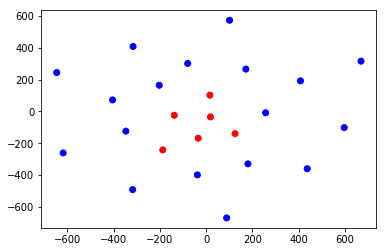

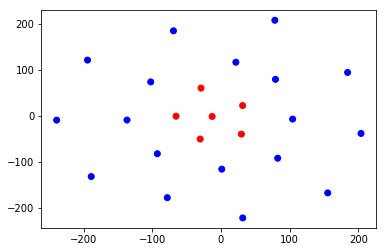

In [29]:
visualize_pca(bon_tfidfs_ngrams_exp + nyingma_tfidfs_ngrams_exp, colors=colors)
visualize_tsne(bon_tfidfs_ngrams_exp + nyingma_tfidfs_ngrams_exp, colors=colors)
visualize_pca_tsne(bon_tfidfs_ngrams_exp + nyingma_tfidfs_ngrams_exp, colors=colors)

In [30]:
bon_tfidfs_ngrams_lin = []
for v in bon_tfidfs_ngrams:
    v = np.copy(v)
    for n in range(10):
        v[ngram_idxs[n]:ngram_idxs[n+1]] *= 2*(n+1)
    bon_tfidfs_ngrams_lin.append(v)
    
nyingma_tfidfs_ngrams_lin = []
for v in nyingma_tfidfs_ngrams:
    v = np.copy(v)
    for n in range(10):
        v[ngram_idxs[n]:ngram_idxs[n+1]] *= 2*(n+1)
    nyingma_tfidfs_ngrams_lin.append(v)

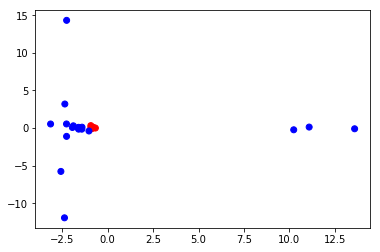

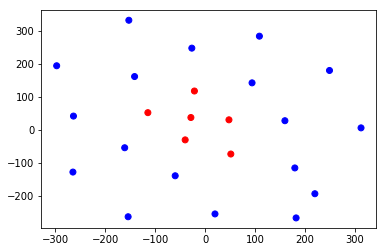

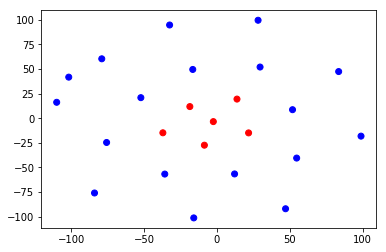

In [31]:
visualize_pca(bon_tfidfs_ngrams_lin + nyingma_tfidfs_ngrams_lin, colors=colors)
visualize_tsne(bon_tfidfs_ngrams_lin + nyingma_tfidfs_ngrams_lin, colors=colors)
visualize_pca_tsne(bon_tfidfs_ngrams_lin + nyingma_tfidfs_ngrams_lin, colors=colors)

## Part 3: LSI (Latent Semantic Indexing)

Latent semantic indexing (also known as latent semantic analysis) entails computing frequency vectors (for instance, tf-idf vectors) per document and then computing a low rank approximation of the data matrix created by stacking frequency vectors horizontally.

The intuition behind this is that we can represent most documents as linear combinations of a set of latent topics, each of which is represented by the remaining singular vectors of the low-rank approximation of the original data matrix.

Another technique that works by modeling these latent topics is LDA (latent dirichlet allocation), which gensim similarly supports.

I leave these techniques yet unimplemented as they require much bigger corpora than we currently have for good performance.

Additionally, from Joey, it is unlikely that LSI outperforms PCA